### Contexto informe

Contexto análitico: Se trata de un conjunto de datos transnacionales que contiene todas las transacciones que se produjeron entre el 12/01/2010 y el 12/09/2011 para una tienda minorista en línea registrada y con sede en el Reino Unido. La empresa vende principalmente regalos únicos para toda ocasión. Muchos clientes de la empresa son mayoristas. Las transacciones están agrupadas a nivel de boleta, cada boleta tiene distintos productos, con descripcón, cantidad comprada, fecha de compra, el precio por unidad, el cliente y el pais donde fue comprado.

Contexto comercial: el quiebre de stock, la rotación de productos y los skus inmovilizados son indicadores claves para gestionar el inventario de una tienda. Si estos indicadores no son los óptimos, la empresa puede perder ventas ponteciales y por lo tanto dejar de percibir ingresos. Además, estar sobre stockeado en productos que no tienen rotación, genera que los skus estén inmovilizados y es dinero que podría estar invertido de otra forma generando más rentabilidad (costo de oportunidad). Dado la anterior, es importante entender la demanda por productos para poder realizar una buena gestión de inventarios.

Problema comercial: El cuando comprar y cuanto comprar son 2 problemas claves para las empresas de retail, ya que el costo de bodegaje, transporte y de oportundidad es elevado y genera pérdida por merma, costos logísticos y perdida potencial de venta. Por lo tanto, es necesario analizar que variables influyen en la demanda de los consumidores y predecir cuanto comprar y en que momento para minimizar los costos lógisticos y maximizar la venta, es decir, maximizar la utilidad.

Objetivo: Analizar los datos y encontrar información relevante para luego predecir en que momento y cuanto comprar con algoritmos que permitan estimar la demanda futura.

Hipótesis:
1.- La demanda de los meses anteriores es la variable más significativa para predecir la demanda futura
2.- Dentro de la demanda existe estacionalidad, es decir que los productos tienene más demanda dependiendo del periodo de tiempo que se esté analizado.
3.- Los productos de mayor valor son los que menos rotan (tienen menos venta respecto a su costo) y los de menor valor los que más rotan
4.- Los clientes compran productos similares a lo largo del tiempo (Cliente recurrente compra los mismos productos)

Variables:
- RowNumber: Número de filas del conjunto de datos
- InvoiceNo: identificador único de la boleta/factura de la venta realizada
- StockCode: Identificador único de los productos
- Description: descripción de cada producto
- Quantity: Cantidad vendida del producto
- InvociceDate: Fecha en que se generó la boleta/venta
- UnitPrice: precio del producto vendido
- CustomerID: identificador único de los clientes
- Country: País donde fue generada la venta

In [34]:
import numpy as np 
import pandas as pd 
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.cluster import KMeans

In [69]:
data=pd.read_csv('data.csv',encoding= 'unicode_escape')
data.head(10)

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55    17850.00  United Kingdom  
1  12/1/2010 8:26       3.39    17850.00  United Kingdom  
2  12/1/2010 8:26       2.75    17850.00  United Kingdom  
3  12/1/2010 8:26       3.39    17850.00  United Kingdom  
4  12/1/2010 8:26       3.39    17850.00  United Kingdom  
5  12/1/2010 8:26       7.65    17850.00  United Kingdom  
6  12/1/2010 8:26       4.25    17850.00  United Kingdom  
7  12/1/2010 8:28       1.85    17850.00  United Kingdom  
8  12/1/2010 8:28       1.85    17850.00  United Kingdom  
9  12/1/2010 8:34       1.69    13047.00  United Kingdom

### Informacion sobre los datos

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Estadísticas sobre los datos

In [37]:
data.describe()

Quantity  UnitPrice  CustomerID
count 541909.00  541909.00   406829.00
mean       9.55       4.61    15287.69
std      218.08      96.76     1713.60
min   -80995.00  -11062.06    12346.00
25%        1.00       1.25    13953.00
50%        3.00       2.08    15152.00
75%       10.00       4.13    16791.00
max    80995.00   38970.00    18287.00

### Devoluciones de productos 
Los datos negativos son devoluciones de productos y se identifican a través de la letra "C" en el comienzo del código de la columna "InvoiceNo". Estos valores afectan a cualquier tipo de análisis acumulado que se quiera realizar, por lo que asumiendo que tienen una causa y no afectan, se decide eliminarlos. 

In [70]:
cancelled = pd.Series(np.where(data.InvoiceNo.apply(lambda x: x[0]=="C"), 'Canceled', 'Not Canceled'))

fig = px.pie(values=cancelled.value_counts(), names=cancelled.value_counts().index, title='Orders Cancelation')
fig.show()



### Identificamos las ordenes de venta canceladas

In [85]:

## Funcion para dejar solo los números de las ordenes
def eliminar_c(lista):
    nueva_lista = []
    for valor in lista:
        valor = valor[1:]
        nueva_lista.append(valor)
    return nueva_lista

df_invoice = data
df_invoice = df_invoice[df_invoice['InvoiceNo'].str.startswith('C')]
delete_this_invoice = df_invoice['InvoiceNo'].drop_duplicates(keep='first', inplace=False)
delete_this_invoice = delete_this_invoice.to_list()
data = data[~data.InvoiceNo.isin(delete_this_invoice)]

##### Además de eliminar las ordenes con el identificador de cancelado, se analizará si existen otros outliers y si es razonable eliminarlos.

<Axes: >

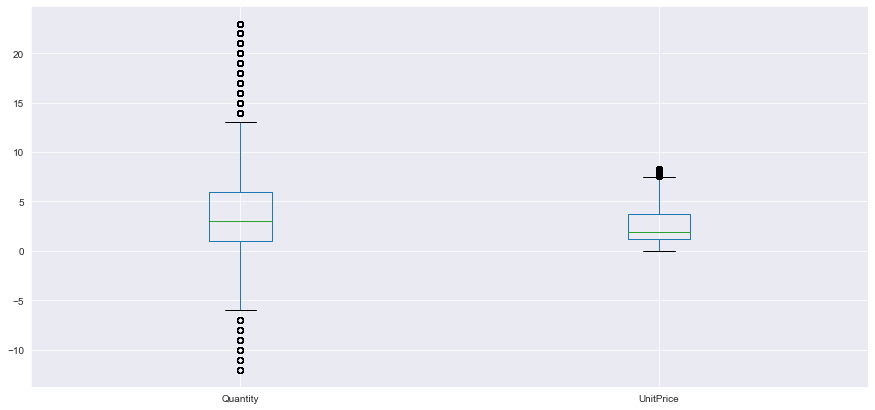

In [86]:
data[['Quantity','UnitPrice']].boxplot(figsize=(15,7))

##### Es posible visualizar que existen outlier cuanto a cantidad como a precio por unidad. En la cantidad, se ve que los valores negativos con los positivos se cancelan, por lo que es posible pensar en que fue una venta mal digitada y posteriorme se canceló con una venta negativa por la misma cantidad. Además existe un precio que alcanza los $40.000 y se escapa mucho de la concentración de precios, por lo que se eliminará junto con el precio negativo.

In [78]:
def remove_outliers(column):
    Q1 = column.quantile(.25)
    Q3 = column.quantile(.75)
    IQR = Q3 - Q1
    column = column[((Q1 - 1.5 * IQR) <= column) & (column  <= (Q3 + 1.5 * IQR))]
    return column

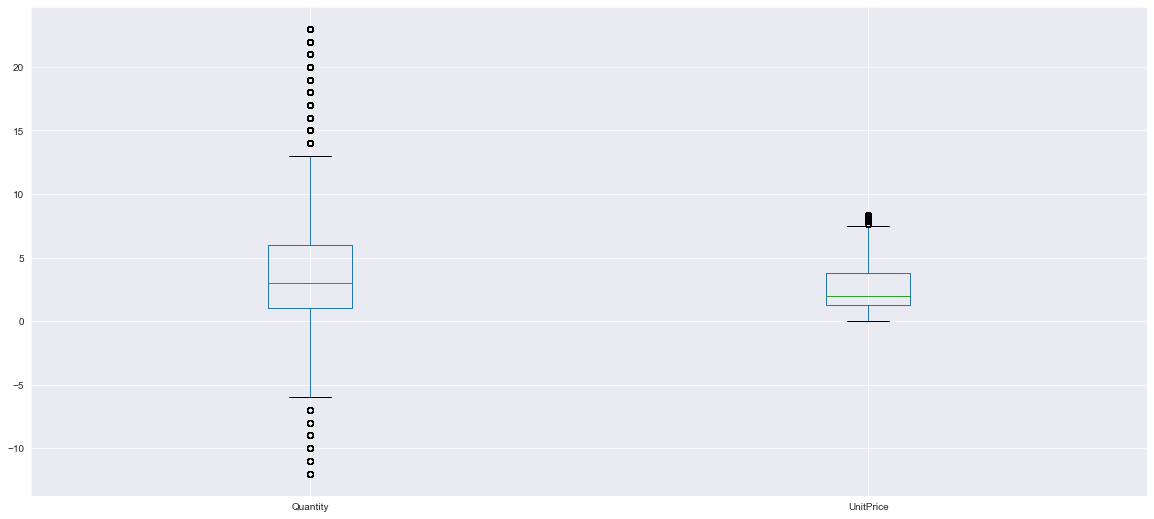

In [79]:
data.Quantity = remove_outliers(data.Quantity)
data.UnitPrice = remove_outliers(data.UnitPrice)
data[['Quantity','UnitPrice']].boxplot(figsize=(20,9));

##### La distribución de valores mejora, pero siguen existiendo valores negativos en la columna cantidad. Previo a eliminarlos, se graficarán histogramas a de ambas variables para ver su distribución

In [80]:
fig = px.histogram(data,x='Quantity',nbins=30)
fig.update_layout(autosize=False, width=950, height=600, xaxis_title="Quantity")
fig.show()

In [ ]:
df_Datos.isnull().sum()

In [ ]:
df_Datos.info()


# Cantidad de compras:25900

In [ ]:
df_Datos.InvoiceNo.value_counts()

# Cantidad de clientes: 4372, Total de compras hechas por clientes

In [ ]:
df_Datos.CustomerID.value_counts()

# Cantidad de productos: 4070 ; cantidad total vendida de cada producto(falta multiplicar por la cantidad)

In [ ]:
df_Datos.StockCode.value_counts()

# 50 productos mas vendidos

In [ ]:
df_Datos.StockCode.value_counts().head(50)

# Cantidad de compras hechas por pais

In [ ]:
df_Datos.Country.value_counts()

In [ ]:
df2 = df_Datos[df_Datos['Country'].isin(['United Kingdom'])]
df2

In [ ]:
df_Datos['InvoiceDate'] = pd.to_datetime(df_Datos['InvoiceDate'])

In [ ]:
df_Datos['año'] = df_Datos['InvoiceDate'].dt.year
df_Datos['mes'] = df_Datos['InvoiceDate'].dt.month
df_Datos['dia'] = df_Datos['InvoiceDate'].dt.day

In [ ]:
df_Datos

In [ ]:
Productos_unicos = df_Datos['StockCode'].unique()

In [ ]:
df3 = df_Datos[df_Datos['StockCode'].isin(['85123A'])]
df3

In [ ]:
Total_85123A = df3['Quantity'].sum()
Total_85123A

In [ ]:
for i in range(len(productos_unicos)):
    productos_unicos[i] = df_Datos
    
    
    
    for nombre, grupo in df_Datos.groupby(['StockCode	', 'Quantity']):
    ventas_totales = grupo['ventas'].sum()
    print(f'{nombre}: {ventas_totales}')

In [ ]:
Por_mes_85123A = df3.groupby(['mes'])['Quantity'].sum().reset_index().sort_values(by='mes', ascending = True)
Por_mes_85123A


In [ ]:
Orden = [12,1,2,3,4,5,6,7,8,9,10,11]
Por_mes_85123A['Orden'] = Orden
Por_mes_85123A

In [ ]:
PM_Por_mes_85123A = Por_mes_85123A.groupby(['Orden'])['Quantity'].sum().reset_index().sort_values(by='Orden', ascending = True)
PM_Por_mes_85123A

In [ ]:
rolling_mean1 = PM_Por_mes_85123A.rolling(window=3).mean()
print(rolling_mean1)

In [ ]:
rolling_mean = Por_mes_85123A.rolling(window=3).mean()
print(rolling_mean)

In [ ]:
Productos = df_Datos.groupby(['StockCode'])['Quantity'].count().reset_index().sort_values(by='Quantity', ascending = False)
Productos.head(10)

In [ ]:
df_Datos['Precio Total'] = df_Datos['Quantity']*df_Datos['UnitPrice']

In [ ]:
df_Datos